# Introduction

Data Science is becoming an increasingly important job. In a data abundant world being able to extract knowledge from data will be became a competitive necessity. In this sense, companies around the world are investing more in their data science teams. According to a 2012 article from [Havard Business Review](https://hbr.org/2012/10/data-scientist-the-sexiest-job-of-the-21st-century) data science will is the most promising jobs for the 21st century. In this notebook we will analyze the evolution in the number of data scientists along the years. For this purpose we will be using the data from Stack Overflow Survey from 2017 to 2020.

## Imports and Configs

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from typing import Any
import seaborn as sns

sns.set(context='notebook', style='whitegrid', font_scale=1)

# Data Loading

To answer the first question, we will be using the data from the surveys from 2017 to 2020. For each year we will load the response data regarding the respondent developer type. After that we remove missing data. Respondents could answer this question by selecting multiple options, such as: 'Mobile developer', 'Graphics programming' and 'Desktop applications developer'.

In [2]:
# loading devtype data from years 2017 to 2020
def load_devtype_answers(file_path: str) -> pd.Series:
    """Loading data of Dev Type answers only works for the data from
    2017 onwards. Select the column name based on the year and only load its
    data into a pd.Series. Remove missing data and return the series.
    """
    
    col = 'DevType' if year > 2017 else 'DeveloperType' # selecting col name according to year
    df = pd.read_csv(file_path, usecols=[col])    # only loading data from the selected col
    devtype_answers = df[col]
    devtype_answers.dropna(inplace=True) # removing missing data
    return devtype_answers

In [3]:
# iterating to all the data located in the data folder
data_folder = 'data'
file_name_suffix = '_data.zip'
devtype_answers = dict()
for year in range(2017, 2021):
    file_name = str(year) + file_name_suffix
    file_path = os.path.join(data_folder, file_name)
    data = load_devtype_answers(file_path)
    devtype_answers[year] = data

For each year the respondents had a number of options that could be selected. It was possibile to select more than one answer. Those options are separated in the data by '; ' (for the 2017 year) or ';' (other years). Depending on the years different options were available for the respondents to select. Bellow we are printing a sample of the data for each year and the list of unique options available for each year.

In [4]:
# for each year we will print a sample from the answers followed by the
# the number of unique options and its values.
for year, data in devtype_answers.items():
    print(f'Sample of developer type answer for the {year} Stack Overflow Survey.', '\n')
    print(data.sample(5), '\n')
    unique_options = data.str.split(';').explode().str.strip().unique()
    print(f'{unique_options.size} unique options:')
    print(unique_options)
    print('#'*70, '\n'*2)

Sample of developer type answer for the 2017 Stack Overflow Survey. 

50032                                     Mobile developer
28113                                        Web developer
24076    Web developer; Mobile developer; Desktop appli...
46500        Web developer; Desktop applications developer
37753                Web developer; Database administrator
Name: DeveloperType, dtype: object 

14 unique options:
['Other' 'Mobile developer' 'Graphics programming'
 'Desktop applications developer' 'Web developer'
 'Embedded applications/devices developer' 'DevOps specialist'
 'Quality assurance engineer' 'Data scientist'
 'Machine learning specialist'
 'Developer with a statistics or mathematics background'
 'Database administrator' 'Systems administrator' 'Graphic designer']
###################################################################### 


Sample of developer type answer for the 2018 Stack Overflow Survey. 

46154    Back-end developer;Designer;Desktop or enterpr...
73235  

# The evolution of the share of Data Scientists

We then compute the percentage of respondents that selected options related to Data Science. By looking at different options available for each year we found that Data Scientists can be identified by selecting respondents whose selected options contained 'Data scientists' or 'Machine learning'.

In [5]:
def gen_ds_percent(devtype: pd.Series) -> float:
    """This function calculates the percentage of respondentents that
    consider itself as being Data Scientists. In 2017 the Data Scientists and
    Machine Learning Specialist were two different options. From 2018, those
    were integrated into a single option. In order to match both cases we will
    be using two diferent conditionals to select Data Scientists.
    """    
    
    ds = devtype.str.contains('Data scientist')
    ml = devtype.str.contains('Machine learning')
    is_data_scientist = ds | ml
    return is_data_scientist.mean()

In [6]:
# calculating the percentages that are data scientistis
ds_percentages = {year: gen_ds_percent(data)
                  for year, data in devtype_answers.items()}
ds_percentages

{2017: 0.09951557093425606,
 2018: 0.07696149753523421,
 2019: 0.07942460195487798,
 2020: 0.08077780028357302}

Plotting the evolution

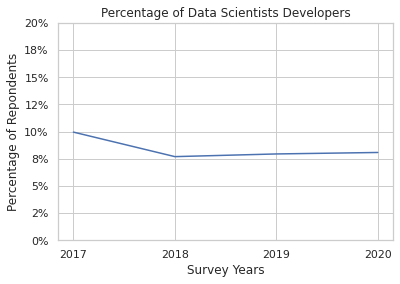

In [7]:
plot_data = pd.Series(ds_percentages)

ax = plot_data.plot()
plt.ylim(0, .2)
plt.xticks(plot_data.index)
ax.yaxis.set_major_formatter(lambda x, p: f'{x:.0%}')
plt.xlabel('Survey Years')
plt.ylabel('Percentage of Repondents')
plt.title('Percentage of Data Scientists Developers')
plt.show()

In [8]:
obs_diff = ds_percentages[2020] - ds_percentages[2017]
print(f'{obs_diff:.2%}')

-1.87%


Contrary to our expectations, from 2017 to 2020 there was a small reduction (-1.87 p.p.) in the percentage of data scientists. Next, we can test if this difference is statiscally significant.

# Hypotesis Testintg: testing the statistical significance of the change

We want to test if the observed percentage of data scientists in 2017 is equal to the observed from 2020. For that purpose we will be making the following hypotesis test:

$$H_0: \mu_{2020} = \mu_{2017} $$
$$H_1: \mu_{2020} \neq \mu_{2017} $$

In a hypothesis test our main objetive is to test our $H_1$ hypothesis, we do it by attempting to reject our $H_0$. Since we can't simultaneously minimize type 1 (rejecting $H_0$ when it is the truth) and type 2 (not rejecting $H_0$ when it is false)) errors we select it is usual decide upon the rejecting of $H_0$ by imposing a limit to the probability of incurring into type 1 error ($\alpha$). A 5% $\alpha$ thereshold will be used to test our hypothesis.

To implement the test we need to reproduce a probability distribution equivalent to our null hypothesis. From this distribution we calculate the probability of getting a value at least as extreme as our observed value (p-value), that is -1.87. If obtained p-value is smaller than our thereshold, we reject our null hypothesis.

Two ways will be explored in order to reproduce our null hypothesis distribution:
  1. Infering a distribution function from our bootstrap replicates.
  2. Generating bootstrap replicates equivalent to our null hypothesis.

This sample result is a convincing evidence against our first hypothesis that there is a rise in the number of data scientists. 

But that result must be further studied. We can test if this difference is statistically significant. But first, we must change our first hypothesis. Instead of testing if there was a rise from to 2017 to 2020, we will be more conservative and test if there was a change. In this sense we can construct our testing hypothesis as such: 

$$H_0: \mu_{2020} = \mu_{2017} $$
$$H_1: \mu_{2020} \neq \mu_{2017} $$

We will test our hypothesis by computing its p-value. That is the probability of getting the observed difference, or more extreme, result under the null hypothesis. First, we need adjust our bootstrap replicates distribution to a case where the null hypothesis is true, that is to a distribution with its mean being equal to zero. There are two ways to do it. We can infer the correct model for our distribution and then through NumPy random module generate the distribution with mean being equal to zero and standard deviation equal to the original bootstrap replicates distribution standard deviation. 

For the other way we do not need to know the correct probability distribution model to reproduce our null hypothesis distribution. We can generate our distribution by treating the 2020 bootstrap replicates and 2017 bootstrap replicates as coming from the same distribution. This can be done by concatenating both data into a single array and them resampling from the single array and computing our differences replicates. With those procedures it is expected the mean from both years would be the same, making our resampled distribution having its mean equal to zero. 

## Null Hypothesis from a Probability Distribution Model

To identify if it is possible to represent our null hypothesis with a distribution model we will through bootstrap replicates resample our differance estimates. Than we will try to identify visualy a model with a good fit in to the ploted distribution. Fortunatly according to the [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem) the sample mean is expected to have a normal distribution.

In [17]:
def bootstrap(data: pd.Series, n=10000) -> np.array:
    """Function to generate our bootstrap samples. The default setting
    is to generate 10.000 replicates. For each iteration it takes a 
    sample with replacement from the series equivalent to the size 
    of the series. From this sample the percentage of data scientists
    estimate is computated and added to the replicate lists. The 
    replicate list is transformed into a numpy array and then it is
    returned as the function output.
    """
    
    sample_size = data.shape[0]
    replicates = []
    for _ in range(n):
        sample = data.sample(sample_size, replace=True)
        replicate = gen_ds_percent(sample)
        replicates.append(replicate)
    return np.array(replicates)

In [18]:
# computing the estimates for each year and then taken their differences.
replicates_2020 = bootstrap(devtype_answers[2020])
replicates_2017 = bootstrap(devtype_answers[2017])

Let us compare both replicates distribution with a boxplot alongside a swarmplot. In order to guarantee a better vizualization of the swarmplot only a small sample of the data will be used. But that will be enought to illustrate both years distributions.

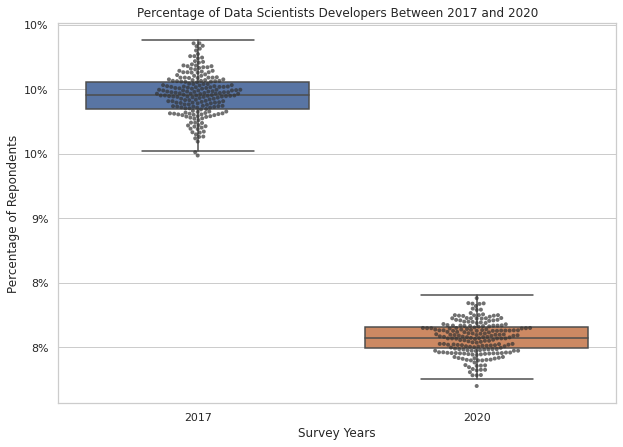

In [19]:
# preparing the data for the plot
# first creating a dataframe for the bloxplot
data = np.array([replicates_2017, replicates_2020]).T
columns = [2017, 2020]
plot_data = pd.DataFrame(data=data, columns=columns)
# than taking a sample and reshaping the table for the swarmplot
sample_swarm = plot_data.sample(200).melt()

# making the plot
fig = plt.figure(figsize=(10, 7))
ax = sns.boxplot(data=plot_data, showfliers=False)
ax = sns.swarmplot(data=sample_swarm, x='variable', y='value', color='.2', alpha=.7, size=4)
ax.yaxis.set_major_formatter(lambda x, p: f'{x:.0%}')
plt.xlabel('Survey Years')
plt.ylabel('Percentage of Repondents')
plt.title('Percentage of Data Scientists Developers Between 2017 and 2020')
plt.show()

From the look of both boxplots it looks like the diffence is statisticaly significant. To formalize this result let us continue with our testing procedures.

To vizualy identify the distribution model, we will first get our values by subtracting our 2017 replicates from the 2020 replicates. Than we will use the normal model function to compute density expected value by using the [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) function and by ploting over the replicates distribution see if it is a good fit to represent it:

$$f(x)=\frac{1}{\sigma \sqrt{2\pi}}e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2}$$


In [56]:
def normal_model(x: np.array) -> tuple:
    x = np.sort(x)
    mu = x.mean()
    sigma = x.std()
    x_norm = (x - mu)/sigma
    
    part1 = sigma * np.sqrt(2 * np.pi)
    part2 = np.exp(-(1/2)*x_norm ** 2)
    return x, part2/part1

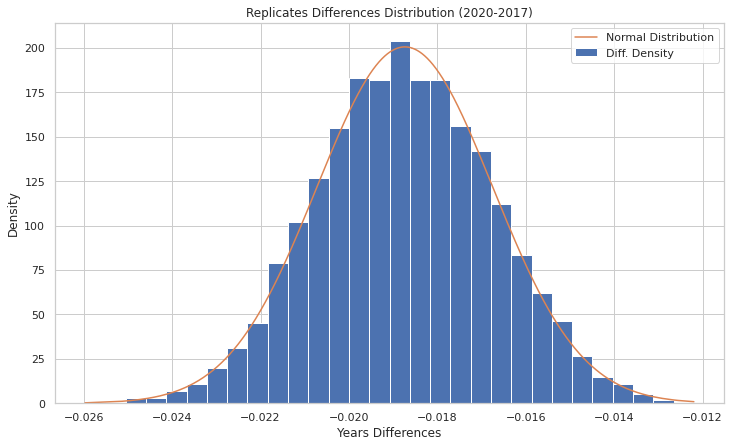

In [58]:
diff_replicates = replicates_2020 - replicates_2017
x_norm, y_norm = normal_model(diff_replicates)

fig = plt.figure(figsize=(12,7))
plt.hist(diff_replicates, density=True, bins=30, label='Diff. Density')
plt.plot(x_norm, y_norm, label='Normal Distribution')
plt.xlabel('Years Differences')
plt.ylabel('Density')
plt.title('Replicates Differences Distribution (2020-2017)')
plt.legend()
plt.show()

Well, from the look of the plot above, it look that the normal distribution is a very good fit for our differences distribution. We can than represent our null hypothesis distribution with a normal distribution with mean equal to zero and standard deviation equal to difference distribution standard deviation. 

In [59]:
# replicates stats
replicates_mean = diff_replicates.mean()
replicates_std = diff_replicates.std()
replicates_size = diff_replicates.size

# null hypothesis values
null_mean = 0
null_vals = np.random.normal(null_mean, replicates_std, replicates_size)

# printing the replicates means and standard deviation
replicates_mean, replicates_std

(-0.018735528899567068, 0.001989232361078664)

Ploting the null hypothesis distribution

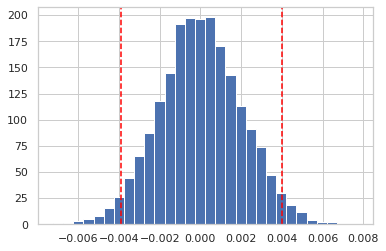

In [24]:
plt.hist(null_vals, density=True, bins=30);
lower, upper = np.percentile(null_vals, [2.5, 97.5])
plt.axvline(lower, color='red', linestyle='--')
plt.axvline(upper, color='red', linestyle='--')
plt.show()

In [16]:
p_value = np.mean(null_vals > upper_bound) + np.mean(null_vals < lower_bound)
p_value

0.0

Here we got a p-value of approximate 0. Approximate in a sense that with a sample of 10.000 we couldn't get any value as extreme as our observed one, but with augment our sample to much more larger values we would probably get a percentage larger than 0. In this sense is more adequate to say that 0 is an approximate value. With this we have evidence strong enough to reject our null hypothesis in favor of our alternative.

## Null hypothesis from bootstrap replicates

Here we get our null hypothesis distribution directly from our bootstrap replicate procedures. Instead of making our bootstrap replicates by resampling from the years specific data, here we concatenate both years data into a single array and then resample. It is like we are saying that both data cames from the same distribution and as such they ought have the same mean. This approach is much simplier and also we don't need to know the correct distrituion model for our null hypothesis.

In [10]:
def is_ds(data):
    ds = data.str.contains('Data scientist')
    ml = data.str.contains('Machine learning')
    is_data_scientist = ds | ml
    return is_data_scientist

In [63]:
def bootstrap_null_vals(data_1, data_2, size=1):
    
    perm_replicates = np.empty(size)
    
    isds_1 = is_ds(data_1)
    isds_2 = is_ds(data_2)
    data = np.concatenate((isds_1, isds_2))
    
    for i in range(size):
        perm_sample_1 = np.random.choice(data, size=len(data_1), replace=True)
        perm_sample_2 = np.random.choice(data, size=len(data_2), replace=True)
        perm_replicates[i] = perm_sample_1.mean() - perm_sample_2.mean()
        
    return perm_replicates

In [64]:
null_replicates = draw_perm_reps(devtype_answers[2020], devtype_answers[2017], 10000)

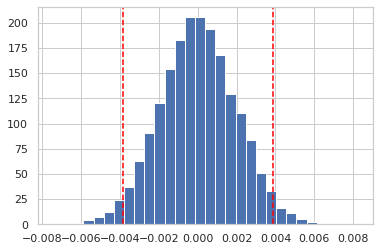

In [65]:
lower, upper = np.percentile(null_replicates, [2.5, 97.5])
plt.hist(null_replicates, density=True, bins=30)
plt.axvline(lower, color='red', linestyle='--')
plt.axvline(upper, color='red', linestyle='--')
plt.show()

In [66]:
(perm_replicates <= obs_diff).mean()

0.0

As expected this result is the same as the past one. In both cases we are rejecting our null hypothesis. As such we can say that the difference from 2017 to 2020 is statiscaly significant.

# Conclusion

Given the estimated p-value of 0, we can reject our null hypotesis that the percentages of data scientsts respondents in 2017 and 2020 are equal. 
Whoever this might have happened as a result of a the large sample that we had in both years.
One limitation of hypotesis testing and confidence intervals is that with a big enough sample, any change could be considered statistically significant.
As the sample size increases the standard deviation of our bootstrap replicates reduces, making it more concentrated aruound the observerd estimate (the expected value).
This reduces our confidence interval, making even small changes statistically significants.
But it is important to keep in mind that statistical signifancy doens't translate automatically into practical significant.
In this sense we can argue that even though a 1.87p.p. reduction from 2017 to 2020 can be statiscally significant, in practical terms it doesn't means much.
As such, even though we data science job is not in the rise anymore, we can't say that is a declining profession.

In [17]:
size_2017 = devtype_answers[2017].shape[0]
size_2020 = devtype_answers[2020].shape[0]
size_2017, size_2020

(36125, 49370)